# Parte 3: Clasificación con Descriptores Clásicos

Este notebook implementa la clasificación de imágenes usando los descriptores extraídos y diferentes algoritmos de machine learning.


In [7]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc, roc_auc_score)

# PyTorch para CNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {device}")


🔧 Dispositivo: cpu


## 1. Carga de Características


In [8]:
# Cargar características extraídas
try:
    features_df = pd.read_csv('../data/features_sample.csv')
    print(f"✅ Características cargadas: {features_df.shape}")
except:
    print("⚠️  No se encontró features_sample.csv")
    print("   Por favor, ejecuta primero el notebook 2_extraccion_descriptores.ipynb")
    raise

# Separar características y etiquetas
X = features_df.drop(['label', 'path'], axis=1).values
y = features_df['label'].values

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\n📊 Dataset:")
print(f"   Muestras: {X.shape[0]}")
print(f"   Características: {X.shape[1]}")
print(f"   Clases: {le.classes_}")
print(f"   Distribución: {np.bincount(y_encoded)}")


✅ Características cargadas: (100, 26340)

📊 Dataset:
   Muestras: 100
   Características: 26338
   Clases: ['NORMAL' 'PNEUMONIA']
   Distribución: [23 77]


## 2. División de Datos y Normalización


In [9]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"📊 División de datos:")
print(f"   Train: {X_train.shape[0]} muestras")
print(f"   Test: {X_test.shape[0]} muestras")

# Limpieza de datos: Detectar y manejar valores infinitos y NaN
print("\n🔍 Verificando calidad de datos...")

# Contar valores infinitos y NaN
inf_count_train = np.isinf(X_train).sum()
nan_count_train = np.isnan(X_train).sum()
inf_count_test = np.isinf(X_test).sum()
nan_count_test = np.isnan(X_test).sum()

print(f"   Valores infinitos - Train: {inf_count_train}, Test: {inf_count_test}")
print(f"   Valores NaN - Train: {nan_count_train}, Test: {nan_count_test}")

# Reemplazar infinitos y NaN
if inf_count_train > 0 or nan_count_train > 0 or inf_count_test > 0 or nan_count_test > 0:
    print("   ⚠️  Limpiando valores problemáticos...")
    
    # Reemplazar infinitos con NaN primero
    X_train = np.where(np.isinf(X_train), np.nan, X_train)
    X_test = np.where(np.isinf(X_test), np.nan, X_test)
    
    # Calcular mediana por columna (ignorando NaN) para reemplazar
    # Solo usar columnas que no sean todas NaN
    valid_cols = ~np.isnan(X_train).all(axis=0)
    if valid_cols.any():
        medians = np.nanmedian(X_train[:, valid_cols], axis=0)
        
        # Reemplazar NaN con la mediana de cada columna
        for i, col_idx in enumerate(np.where(valid_cols)[0]):
            col_median = medians[i]
            if not np.isnan(col_median) and not np.isinf(col_median):
                X_train[:, col_idx] = np.where(np.isnan(X_train[:, col_idx]), col_median, X_train[:, col_idx])
                X_test[:, col_idx] = np.where(np.isnan(X_test[:, col_idx]), col_median, X_test[:, col_idx])
    
    # Para columnas que son todas NaN o que aún tienen NaN, reemplazar con 0
    nan_cols = np.isnan(X_train).any(axis=0)
    if nan_cols.any():
        X_train[:, nan_cols] = np.nan_to_num(X_train[:, nan_cols], nan=0.0, posinf=0.0, neginf=0.0)
        X_test[:, nan_cols] = np.nan_to_num(X_test[:, nan_cols], nan=0.0, posinf=0.0, neginf=0.0)
        print(f"   ⚠️  {nan_cols.sum()} columnas con NaN fueron reemplazadas con 0")
    
    # Verificar que no queden valores problemáticos
    remaining_inf = np.isinf(X_train).sum() + np.isinf(X_test).sum()
    remaining_nan = np.isnan(X_train).sum() + np.isnan(X_test).sum()
    
    if remaining_inf == 0 and remaining_nan == 0:
        print("   ✅ Datos limpiados exitosamente")
    else:
        print(f"   ⚠️  Aún quedan {remaining_inf} infinitos y {remaining_nan} NaN")
        # Última medida: reemplazar cualquier valor problemático restante con 0
        X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
        X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
        print("   ✅ Valores problemáticos reemplazados con 0")
else:
    print("   ✅ No se encontraron valores problemáticos")

# Normalización
print("\n📊 Normalizando datos...")
scaler_standard = StandardScaler()
X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

print(f"\n✅ Datos normalizados:")
print(f"   StandardScaler: media={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")
print(f"   MinMaxScaler: min={X_train_minmax.min():.4f}, max={X_train_minmax.max():.4f}")


📊 División de datos:
   Train: 80 muestras
   Test: 20 muestras

🔍 Verificando calidad de datos...
   Valores infinitos - Train: 837, Test: 197
   Valores NaN - Train: 0, Test: 0
   ⚠️  Limpiando valores problemáticos...
   ⚠️  4 columnas con NaN fueron reemplazadas con 0
   ✅ Datos limpiados exitosamente

📊 Normalizando datos...

✅ Datos normalizados:
   StandardScaler: media=-0.0000, std=0.9999
   MinMaxScaler: min=0.0000, max=1.0000


## 3. Reducción de Dimensionalidad


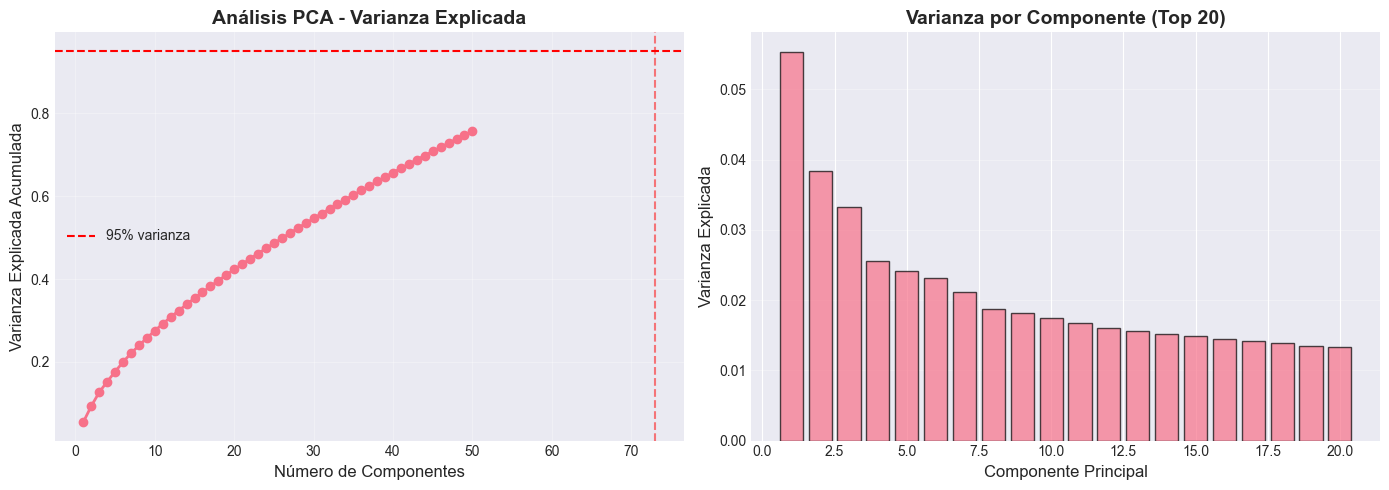

📊 Análisis PCA:
   Componentes para 95% varianza: 73
   Reducción: 26338 → 73 características
   Aplicado PCA con 50 componentes


In [10]:
# PCA - Análisis de varianza explicada
pca_full = PCA()
pca_full.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Encontrar número de componentes para 95% de varianza
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Varianza explicada
axes[0].plot(range(1, min(50, len(cumulative_variance)) + 1), 
            cumulative_variance[:50], marker='o', linewidth=2)
axes[0].axhline(0.95, color='r', linestyle='--', label='95% varianza')
axes[0].axvline(n_components_95, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Número de Componentes', fontsize=12)
axes[0].set_ylabel('Varianza Explicada Acumulada', fontsize=12)
axes[0].set_title('Análisis PCA - Varianza Explicada', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Varianza por componente
axes[1].bar(range(1, min(20, len(pca_full.explained_variance_ratio_)) + 1),
           pca_full.explained_variance_ratio_[:20], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Componente Principal', fontsize=12)
axes[1].set_ylabel('Varianza Explicada', fontsize=12)
axes[1].set_title('Varianza por Componente (Top 20)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/pca_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Análisis PCA:")
print(f"   Componentes para 95% varianza: {n_components_95}")
print(f"   Reducción: {X_train_scaled.shape[1]} → {n_components_95} características")

# Aplicar PCA
n_components = min(n_components_95, 50)  # Limitar a 50 para eficiencia
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"   Aplicado PCA con {n_components} componentes")


## 4. Entrenamiento y Evaluación de Clasificadores

### 4.1 Función de Evaluación


In [11]:
def evaluate_classifier(clf, X_train, X_test, y_train, y_test, 
                        classifier_name="Classifier", cv=5):
    """
    Evalúa un clasificador con múltiples métricas.
    """
    # Entrenar
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Validación cruzada
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC AUC (si hay probabilidades)
    roc_auc = None
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results = {
        'classifier': classifier_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results

def plot_confusion_matrix(cm, class_names, title="Matriz de Confusión"):
    """Visualiza matriz de confusión"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()
    return plt.gcf()

print("✅ Funciones de evaluación definidas")


✅ Funciones de evaluación definidas



🔄 Entrenando SVM Linear...
   Accuracy: 0.8000
   F1-Score: 0.7451
   CV Accuracy: 0.8625 (±0.0829)

🔄 Entrenando SVM RBF...
   Accuracy: 0.7500
   F1-Score: 0.6429
   CV Accuracy: 0.7750 (±0.0306)

🔄 Entrenando SVM Polynomial...
   Accuracy: 0.7500
   F1-Score: 0.6429
   CV Accuracy: 0.7750 (±0.0306)


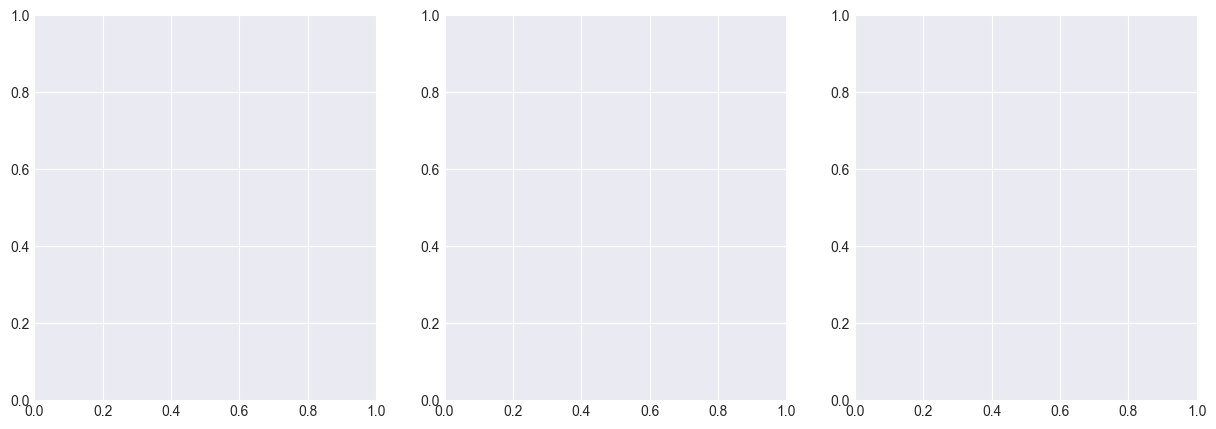

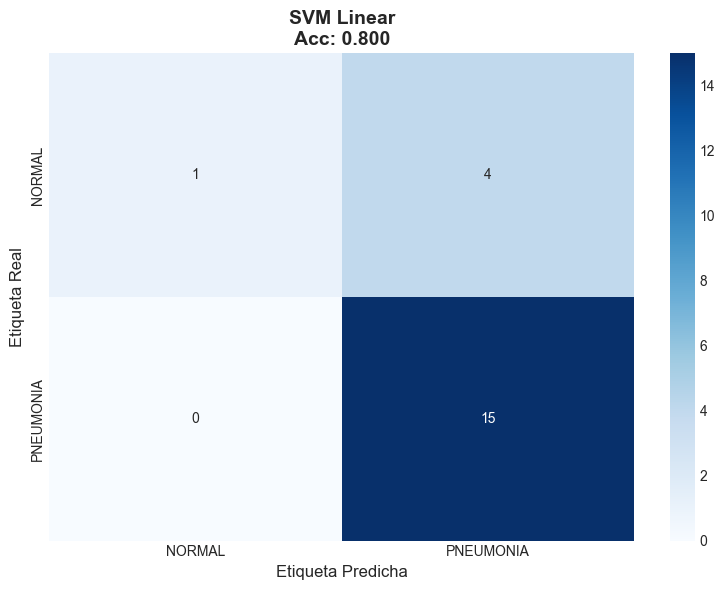

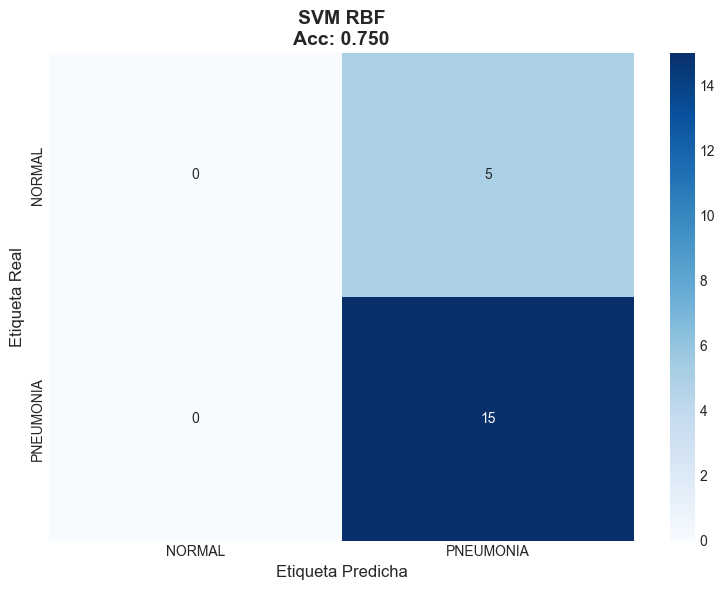

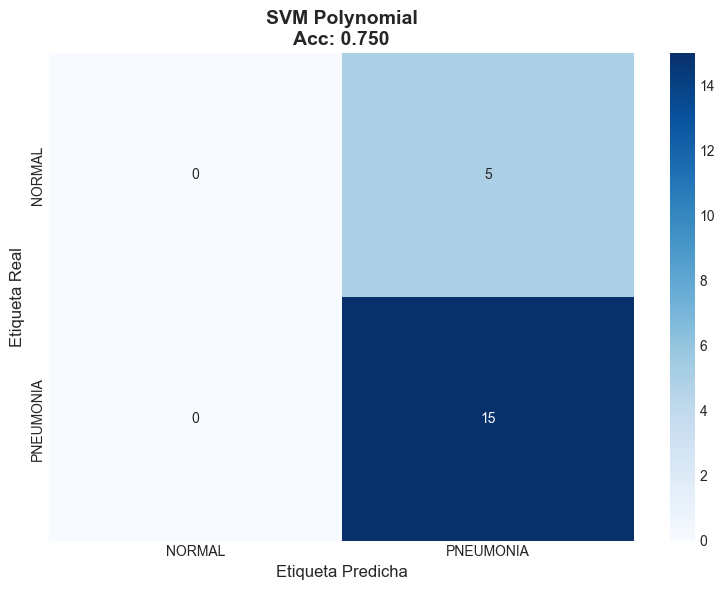

In [12]:
# SVM con diferentes kernels
svm_models = {
    'SVM Linear': SVC(kernel='linear', probability=True, random_state=42),
    'SVM RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM Polynomial': SVC(kernel='poly', degree=3, probability=True, random_state=42)
}

svm_results = {}

for name, model in svm_models.items():
    print(f"\n🔄 Entrenando {name}...")
    result = evaluate_classifier(model, X_train_scaled, X_test_scaled, 
                                 y_train, y_test, classifier_name=name)
    svm_results[name] = result
    print(f"   Accuracy: {result['accuracy']:.4f}")
    print(f"   F1-Score: {result['f1_score']:.4f}")
    print(f"   CV Accuracy: {result['cv_mean']:.4f} (±{result['cv_std']:.4f})")

# Visualizar resultados SVM
fig, axes = plt.subplots(1, len(svm_results), figsize=(5*len(svm_results), 5))

for idx, (name, result) in enumerate(svm_results.items()):
    plot_confusion_matrix(result['confusion_matrix'], le.classes_, 
                         title=f'{name}\nAcc: {result["accuracy"]:.3f}')
    plt.savefig(f'../results/cm_{name.lower().replace(" ", "_")}.png', 
               dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()


### 4.3 Random Forest


🔄 Entrenando Random Forest...
   Accuracy: 0.7500
   F1-Score: 0.6429
   CV Accuracy: 0.7625 (±0.0250)


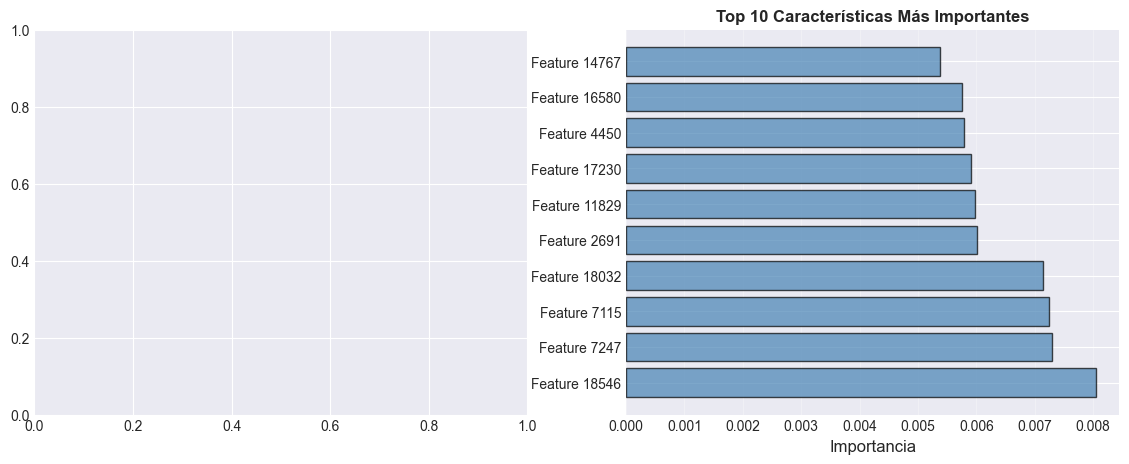

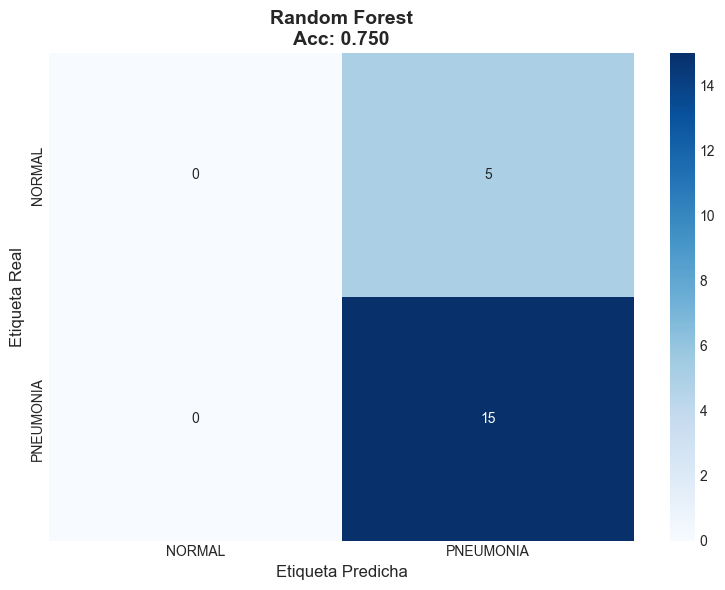

In [13]:
# Random Forest
print("🔄 Entrenando Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_result = evaluate_classifier(rf, X_train_scaled, X_test_scaled, 
                               y_train, y_test, classifier_name='Random Forest')

print(f"   Accuracy: {rf_result['accuracy']:.4f}")
print(f"   F1-Score: {rf_result['f1_score']:.4f}")
print(f"   CV Accuracy: {rf_result['cv_mean']:.4f} (±{rf_result['cv_std']:.4f})")

# Importancia de características
feature_importance = rf.feature_importances_
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión
plot_confusion_matrix(rf_result['confusion_matrix'], le.classes_, 
                     title=f'Random Forest\nAcc: {rf_result["accuracy"]:.3f}')
plt.savefig('../results/cm_random_forest.png', dpi=150, bbox_inches='tight')

# Importancia de características (top 10)
axes[1].barh(range(len(top_features_idx)), feature_importance[top_features_idx], 
            color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(top_features_idx)))
axes[1].set_yticklabels([f'Feature {i}' for i in top_features_idx])
axes[1].set_xlabel('Importancia', fontsize=12)
axes[1].set_title('Top 10 Características Más Importantes', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/rf_importance.png', dpi=150, bbox_inches='tight')
plt.show()


### 4.4 k-Nearest Neighbors (k-NN)



🔄 Entrenando k-NN (k=3)...
   Accuracy: 0.8000

🔄 Entrenando k-NN (k=5)...
   Accuracy: 0.8000

🔄 Entrenando k-NN (k=7)...
   Accuracy: 0.8000

🔄 Entrenando k-NN (k=9)...
   Accuracy: 0.8000

🔄 Entrenando k-NN (k=11)...
   Accuracy: 0.8000


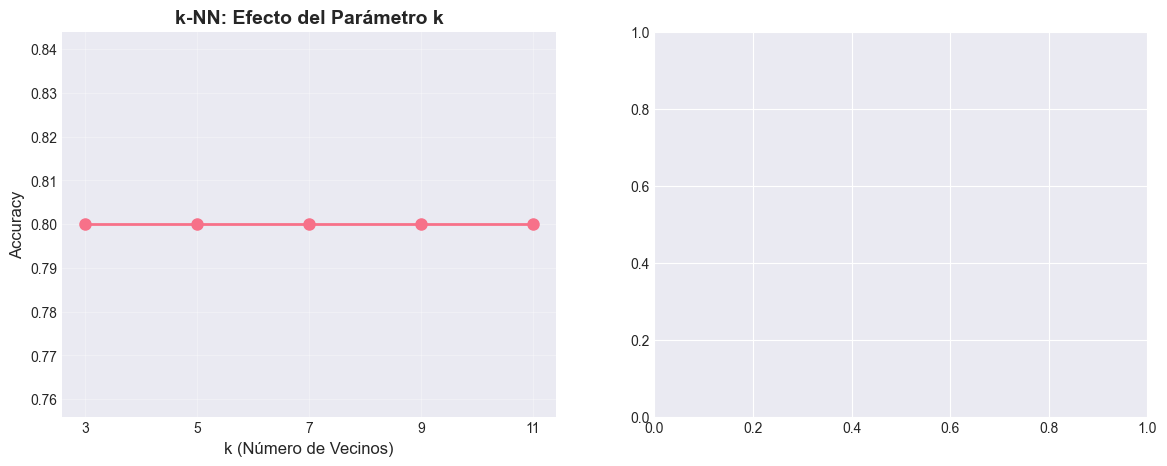

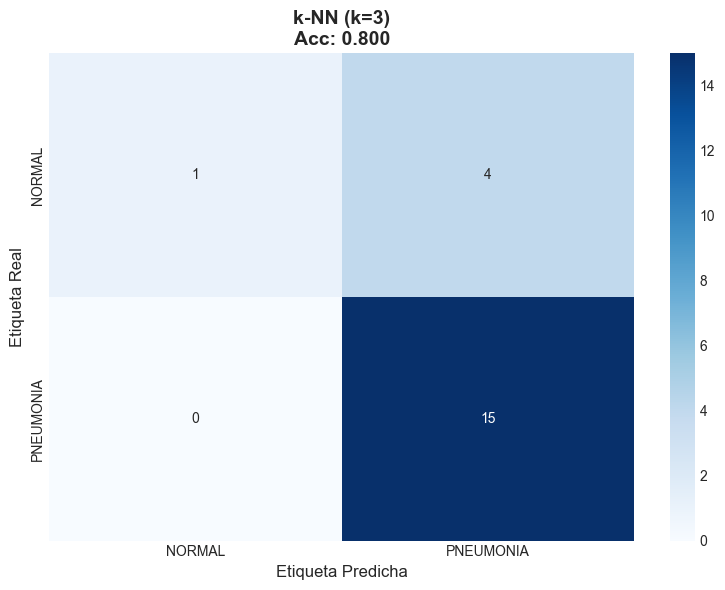


✅ Mejor k: 3 con accuracy: 0.8000


In [14]:
# k-NN con diferentes valores de k
k_values = [3, 5, 7, 9, 11]
knn_results = {}

for k in k_values:
    print(f"\n🔄 Entrenando k-NN (k={k})...")
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    result = evaluate_classifier(knn, X_train_scaled, X_test_scaled, 
                                y_train, y_test, classifier_name=f'k-NN (k={k})')
    knn_results[k] = result
    print(f"   Accuracy: {result['accuracy']:.4f}")

# Visualizar efecto de k
k_accuracies = [knn_results[k]['accuracy'] for k in k_values]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_values, k_accuracies, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('k (Número de Vecinos)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('k-NN: Efecto del Parámetro k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Mejor k-NN
best_k = k_values[np.argmax(k_accuracies)]
best_knn_result = knn_results[best_k]
plot_confusion_matrix(best_knn_result['confusion_matrix'], le.classes_,
                     title=f'k-NN (k={best_k})\nAcc: {best_knn_result["accuracy"]:.3f}')
plt.savefig('../results/cm_knn.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

print(f"\n✅ Mejor k: {best_k} con accuracy: {best_knn_result['accuracy']:.4f}")


### 4.5 Logistic Regression


🔄 Entrenando Logistic Regression...
   Accuracy: 0.8000
   F1-Score: 0.7451
   CV Accuracy: 0.8750 (±0.0791)


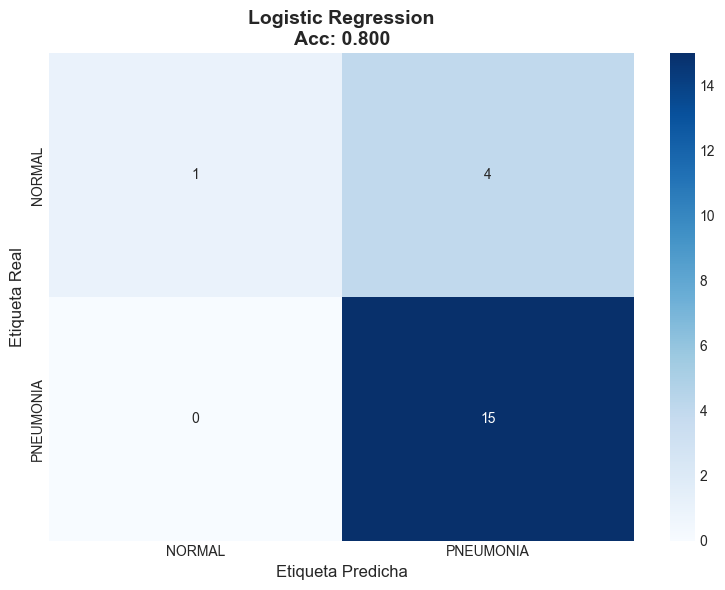

In [15]:
# Logistic Regression
print("🔄 Entrenando Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_result = evaluate_classifier(lr, X_train_scaled, X_test_scaled, 
                               y_train, y_test, classifier_name='Logistic Regression')

print(f"   Accuracy: {lr_result['accuracy']:.4f}")
print(f"   F1-Score: {lr_result['f1_score']:.4f}")
print(f"   CV Accuracy: {lr_result['cv_mean']:.4f} (±{lr_result['cv_std']:.4f})")

# Visualizar
plot_confusion_matrix(lr_result['confusion_matrix'], le.classes_,
                     title=f'Logistic Regression\nAcc: {lr_result["accuracy"]:.3f}')
plt.savefig('../results/cm_logistic_regression.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Comparación de Modelos



📊 Comparación de Modelos:
         Classifier  Accuracy  Precision  Recall  F1-Score  CV Mean   CV Std  ROC AUC
         SVM Linear      0.80   0.842105    0.80  0.745098   0.8625 0.082916 0.973333
            SVM RBF      0.75   0.562500    0.75  0.642857   0.7750 0.030619 0.920000
     SVM Polynomial      0.75   0.562500    0.75  0.642857   0.7750 0.030619 0.093333
      Random Forest      0.75   0.562500    0.75  0.642857   0.7625 0.025000 0.940000
         k-NN (k=3)      0.80   0.842105    0.80  0.745098   0.8250 0.082916 0.693333
Logistic Regression      0.80   0.842105    0.80  0.745098   0.8750 0.079057 0.986667


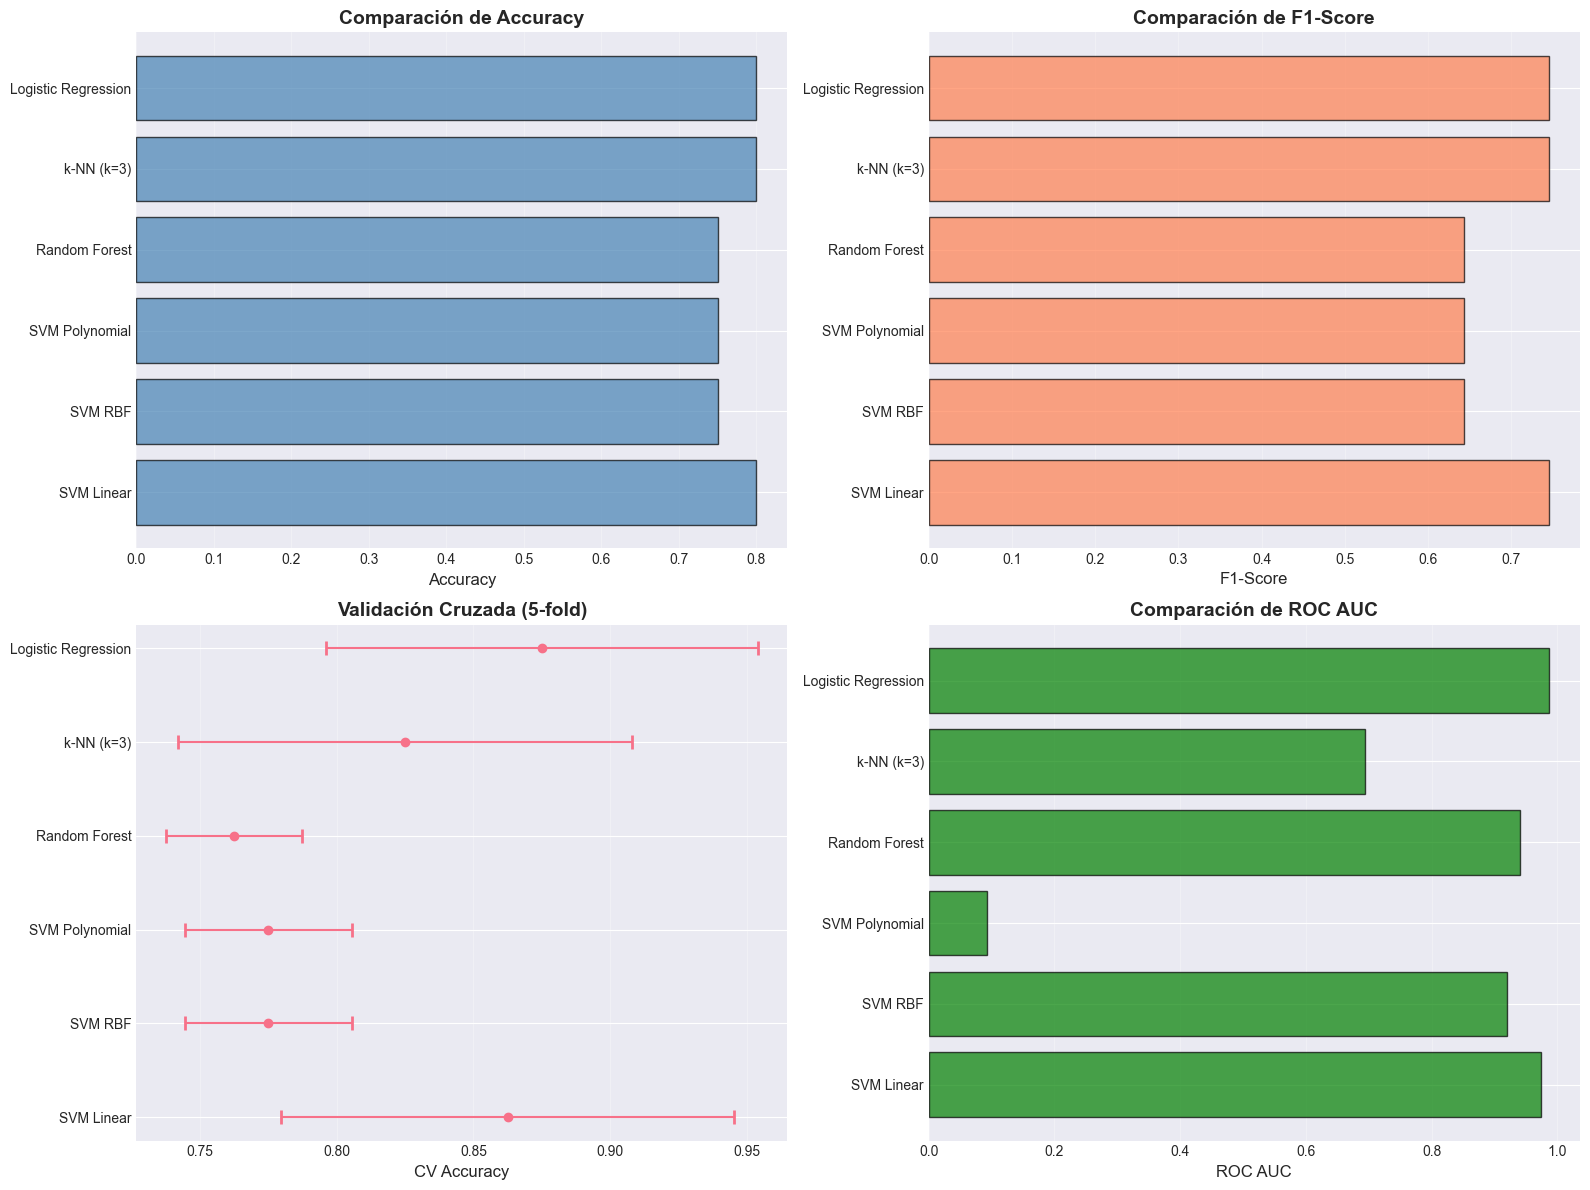

In [16]:
# Recopilar todos los resultados
all_results = list(svm_results.values()) + [rf_result, best_knn_result, lr_result]

# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Classifier': [r['classifier'] for r in all_results],
    'Accuracy': [r['accuracy'] for r in all_results],
    'Precision': [r['precision'] for r in all_results],
    'Recall': [r['recall'] for r in all_results],
    'F1-Score': [r['f1_score'] for r in all_results],
    'CV Mean': [r['cv_mean'] for r in all_results],
    'CV Std': [r['cv_std'] for r in all_results],
    'ROC AUC': [r['roc_auc'] if r['roc_auc'] is not None else np.nan for r in all_results]
})

print("\n📊 Comparación de Modelos:")
print(comparison_df.to_string(index=False))

# Visualizar comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].barh(comparison_df['Classifier'], comparison_df['Accuracy'], 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# F1-Score
axes[0, 1].barh(comparison_df['Classifier'], comparison_df['F1-Score'], 
               color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Comparación de F1-Score', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# CV Accuracy con barras de error
axes[1, 0].errorbar(comparison_df['CV Mean'], comparison_df['Classifier'], 
                    xerr=comparison_df['CV Std'], fmt='o', capsize=5, capthick=2)
axes[1, 0].set_xlabel('CV Accuracy', fontsize=12)
axes[1, 0].set_title('Validación Cruzada (5-fold)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# ROC AUC (si está disponible)
roc_available = comparison_df['ROC AUC'].notna()
if roc_available.any():
    axes[1, 1].barh(comparison_df[roc_available]['Classifier'], 
                   comparison_df[roc_available]['ROC AUC'], 
                   color='green', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('ROC AUC', fontsize=12)
    axes[1, 1].set_title('Comparación de ROC AUC', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
else:
    axes[1, 1].text(0.5, 0.5, 'ROC AUC no disponible\npara todos los modelos', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Curvas ROC


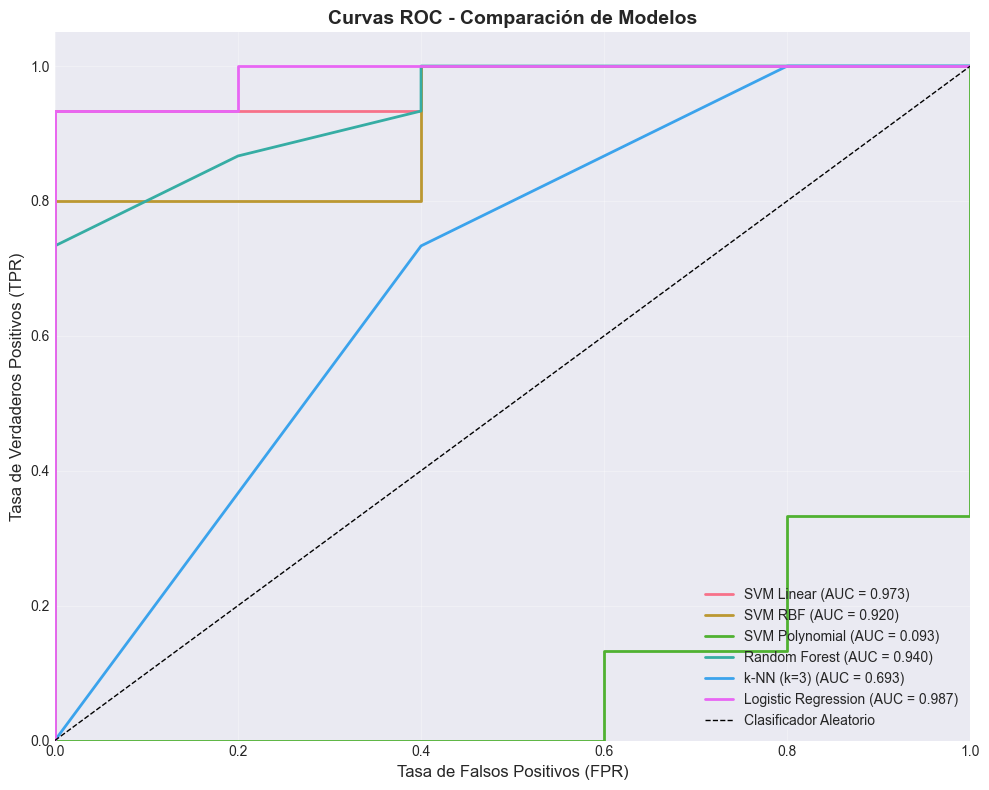

In [17]:
# Graficar curvas ROC para modelos con predict_proba
plt.figure(figsize=(10, 8))

for result in all_results:
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, 
                label=f"{result['classifier']} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Clasificación con CNN (PyTorch)

Implementación de una red neuronal convolucional para comparar con los métodos clásicos.


In [18]:
# Cargar imágenes directamente para CNN
import cv2
from pathlib import Path

# Dataset personalizado
class ChestXRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        
        # Cargar imagen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)  # Convertir a RGB
        img = img.transpose(2, 0, 1)  # HWC -> CHW
        img = img.astype(np.float32) / 255.0
        
        # Aplicar transformaciones
        if self.transform:
            img = self.transform(torch.from_numpy(img))
        
        # Codificar etiqueta
        label_encoded = 1 if label == 'PNEUMONIA' else 0
        
        return img, label_encoded

# Preparar datos para CNN
train_df_cnn = features_df[features_df['path'].isin(
    pd.read_csv('../data/metadata.csv')['path']
)].sample(frac=0.8, random_state=42)
test_df_cnn = features_df[~features_df.index.isin(train_df_cnn.index)]

train_dataset = ChestXRayDataset(train_df_cnn)
test_dataset = ChestXRayDataset(test_df_cnn)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Datasets CNN creados:")
print(f"   Train: {len(train_dataset)} muestras")
print(f"   Test: {len(test_dataset)} muestras")


✅ Datasets CNN creados:
   Train: 80 muestras
   Test: 20 muestras


🔄 Entrenando CNN...
   (Nota: Esto es una versión simplificada. Para entrenamiento completo,
    ajustar epochs, learning rate, y usar GPU si está disponible)
   Epoch 1/3, Loss: 2.0772
   Epoch 2/3, Loss: 0.6015
   Epoch 3/3, Loss: 0.5727

✅ CNN Evaluado:
   Accuracy: 0.6500
   F1-Score: 0.5121
   ROC AUC: 0.7802


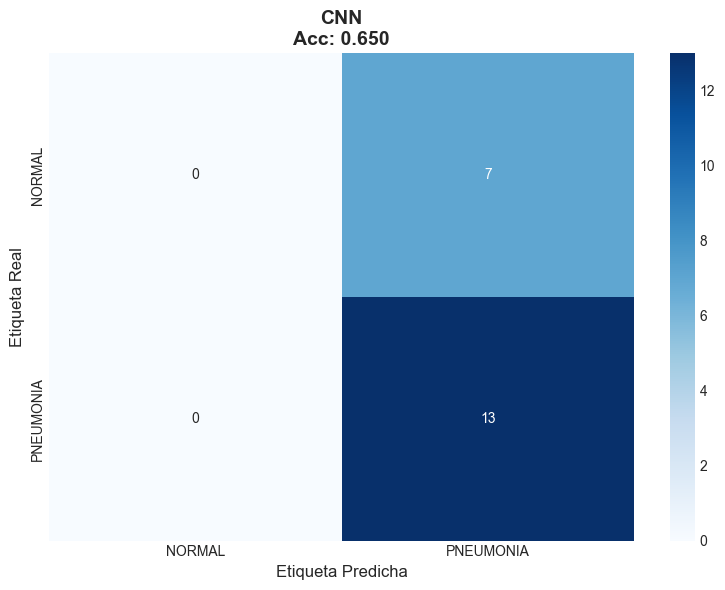

In [19]:
# Modelo CNN simple
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Entrenar CNN (versión simplificada para demostración)
print("🔄 Entrenando CNN...")
print("   (Nota: Esto es una versión simplificada. Para entrenamiento completo,")
print("    ajustar epochs, learning rate, y usar GPU si está disponible)")

model = SimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento rápido (solo unas pocas épocas para demostración)
num_epochs = 3
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"   Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluar CNN
model.eval()
y_pred_cnn = []
y_true_cnn = []
y_pred_proba_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
        
        y_pred_cnn.extend(predicted.cpu().numpy())
        y_true_cnn.extend(labels.cpu().numpy())
        y_pred_proba_cnn.extend(probabilities[:, 1].cpu().numpy())

y_pred_cnn = np.array(y_pred_cnn)
y_true_cnn = np.array(y_true_cnn)
y_pred_proba_cnn = np.array(y_pred_proba_cnn)

# Calcular métricas CNN
cnn_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_precision = precision_score(y_true_cnn, y_pred_cnn, average='weighted', zero_division=0)
cnn_recall = recall_score(y_true_cnn, y_pred_cnn, average='weighted', zero_division=0)
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted', zero_division=0)
cnn_roc_auc = roc_auc_score(y_true_cnn, y_pred_proba_cnn)

print(f"\n✅ CNN Evaluado:")
print(f"   Accuracy: {cnn_accuracy:.4f}")
print(f"   F1-Score: {cnn_f1:.4f}")
print(f"   ROC AUC: {cnn_roc_auc:.4f}")

# Visualizar resultados CNN
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plot_confusion_matrix(cm_cnn, ['NORMAL', 'PNEUMONIA'],
                     title=f'CNN\nAcc: {cnn_accuracy:.3f}')
plt.savefig('../results/cm_cnn.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Resumen Final

Comparación completa entre métodos clásicos y deep learning.



📊 RESUMEN FINAL - COMPARACIÓN DE MÉTODOS
         Classifier  Accuracy  Precision  Recall  F1-Score  ROC AUC
         SVM Linear      0.80   0.842105    0.80  0.745098 0.973333
            SVM RBF      0.75   0.562500    0.75  0.642857 0.920000
     SVM Polynomial      0.75   0.562500    0.75  0.642857 0.093333
      Random Forest      0.75   0.562500    0.75  0.642857 0.940000
         k-NN (k=3)      0.80   0.842105    0.80  0.745098 0.693333
Logistic Regression      0.80   0.842105    0.80  0.745098 0.986667
      CNN (PyTorch)      0.65   0.422500    0.65  0.512121 0.780220

✅ Resultados guardados en '../results/final_comparison.csv'


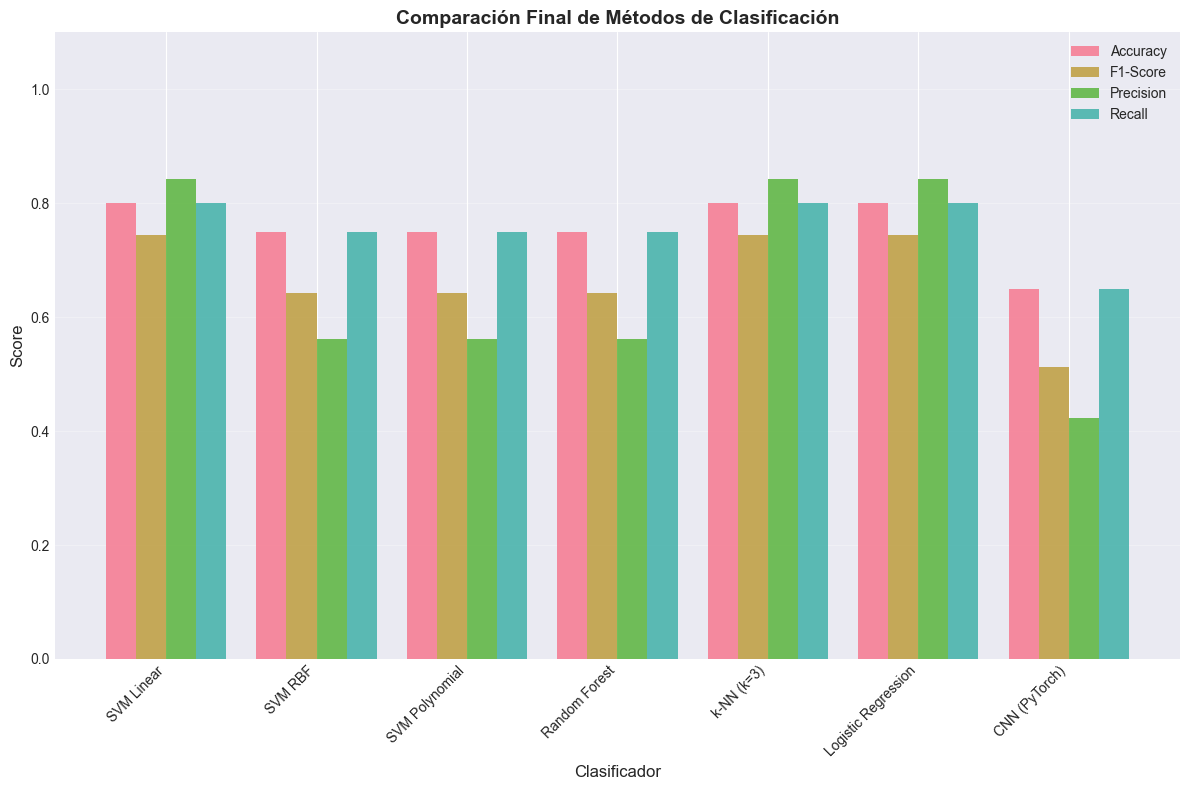

In [20]:
# Agregar CNN a la comparación
cnn_result = {
    'classifier': 'CNN (PyTorch)',
    'accuracy': cnn_accuracy,
    'precision': cnn_precision,
    'recall': cnn_recall,
    'f1_score': cnn_f1,
    'roc_auc': cnn_roc_auc
}

final_comparison = pd.DataFrame({
    'Classifier': [r['classifier'] for r in all_results] + ['CNN (PyTorch)'],
    'Accuracy': [r['accuracy'] for r in all_results] + [cnn_accuracy],
    'Precision': [r['precision'] for r in all_results] + [cnn_precision],
    'Recall': [r['recall'] for r in all_results] + [cnn_recall],
    'F1-Score': [r['f1_score'] for r in all_results] + [cnn_f1],
    'ROC AUC': [r['roc_auc'] if r['roc_auc'] is not None else np.nan 
                for r in all_results] + [cnn_roc_auc]
})

print("\n" + "="*80)
print("📊 RESUMEN FINAL - COMPARACIÓN DE MÉTODOS")
print("="*80)
print(final_comparison.to_string(index=False))
print("="*80)

# Guardar resultados
final_comparison.to_csv('../results/final_comparison.csv', index=False)
print("\n✅ Resultados guardados en '../results/final_comparison.csv'")

# Visualización final
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = np.arange(len(final_comparison))
width = 0.2

ax.bar(x - 1.5*width, final_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - 0.5*width, final_comparison['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.bar(x + 0.5*width, final_comparison['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x + 1.5*width, final_comparison['Recall'], width, label='Recall', alpha=0.8)

ax.set_xlabel('Clasificador', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparación Final de Métodos de Clasificación', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(final_comparison['Classifier'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('../results/final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
